# Machine Learning for Predicting Stock Daily Returns

In [1]:
%matplotlib inline

In [2]:
#!pip install cufflinks plotly

In [3]:
#standard imports for calculations, dataframes work and plotting - check this again
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import seaborn as sns
import pandas_datareader as web
from pandas.plotting import autocorrelation_plot as acp

#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

#holidays handling
from pandas.tseries.offsets import BDay

#fixing an issue with pandas and matplotlib regarding datetime index
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#interactive plotting
import plotly.express as px
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import ipywidgets as w
from matplotlib.widgets import Slider

np.random.seed(2209)

Write some info about the indexes that I will use for predictors

### Below we list all functions we use in further the project

TODO: Put it in the content menu

In [4]:
def set_date_index(data):
    data.Date = pd.to_datetime(data.Date)    
    #set index
    data = data.set_index("Date")
    return data

In [5]:
def rename_columns(data):
    data = data.rename(columns = {
        "Open": "open",
        "High": "high", 
        "Low": "low",     
        "Close": "close",
        "Volume": "volume",
        "Dividends": "dividends",
        "Stock Splits": "stock_splits"})
    return data

In [6]:
def plot_stock_data(data, stock_name, color, scale):
    """ Plot data using, allowing to chose my y-scale
    """
    plt.rcParams.update({'font.size': 14})
    plt.plot(data, color = color, label = stock_name, linewidth = 1)
    plt.yscale(scale)
    plt.xlabel('Year')
    plt.ylabel("Price ($)")
    plt.legend(loc = "best")
    plt.grid(b = True, which = "both", linestyle = '--', linewidth = 1, alpha = 0.5)

In [125]:
def plot_data(df):    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['open'],
                    name="Open",
                    line_color='blueviolet',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['high'],
                    name="High",
                    line_color='green',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['low'],
                    name="Low",
                    line_color='red',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['close'],
                    name="Close",
                    line_color='darkkhaki',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['volume'],
                    name="Volume",
                    line_color='darkgoldenrod',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['dividends'],
                    name="Dividends",
                    line_color='brown',
                    opacity=0.8))
    
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['stock_splits'],
                    name="Stock splits",
                    line_color='brown',
                    opacity=0.8))

    fig.update_layout(title_text='Explore data',
                  xaxis_rangeslider_visible=True)   
    fig.show()

In [7]:
#TODO: Write formulas in the theory part of the project, explain more as a text. 
#ToDO: Explain why close not adj. close and why log not standard!!!!
def calculate_log_return(data_close, data_open):
    """ The logarithmic return or continuously compounded return.
    R_log = ln(V_f/V_i),
    where:
     V_f = final value in the end of the period
     V_i = initial value
    """
    data_return = np.log(data_close/data_open) * 100
    return data_return

In [8]:
def calculate_return(data_close, data_open):
    """ The return over a single period of any length of time.
    R = (V_f - V_i)/V_i
    where:
     V_f = final value in the end of the period
     V_i = initial value
    """
    data_return = (data_close - data_open) / data_open * 100
    return data_return

In [102]:
#write documentation, change some names to better describe
def test_stationarity(timeseries):
    """ The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root,
    with the alternative that there is no unit root. If the pvalue is above a critical size,
    then we cannot reject that there is a unit root.
    """
    plt.figure(figsize = (16,8), linewidth=3, frameon = False)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = 63).mean() #choosing this window because ...
    rolstd = timeseries.rolling(window = 63).std()
    
    #Plot rolling statistics:
    
    orig = plt.plot(timeseries, color = 'green',label = 'Original')
    mean = plt.plot(rolmean, color = 'orange', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'purple', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Augmented Dickey-Fuller test')
    plt.grid(b = True, which = "both", linestyle = '--', linewidth = 1, alpha = 0.5)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
#Reading our data
msft_data = pd.read_csv("microsoft_stock_data.csv")

In [11]:
spy_500 = pd.read_csv("spy_data.csv")
spy_500.tail()

Date     Open     High      Low    Close      Volume  Dividends  \
8483  2019-11-06  3075.10  3078.34  3065.89  3076.78  4458190000          0   
8484  2019-11-07  3087.02  3097.77  3080.23  3085.18  4144640000          0   
8485  2019-11-08  3081.25  3093.09  3073.58  3093.08  3499150000          0   
8486  2019-11-11  3080.33  3088.33  3075.82  3087.01  3035530000          0   
8487  2019-11-12  3089.28  3102.61  3084.73  3091.84  3466010000          0   

      Stock Splits  
8483             0  
8484             0  
8485             0  
8486             0  
8487             0

In [12]:
nasdaq = pd.read_csv("nasdaq_data.csv")
nasdaq.tail()

Date     Open     High      Low    Close      Volume  Dividends  \
8483  2019-11-06  8426.57  8426.57  8379.33  8410.63  2332650000          0   
8484  2019-11-07  8455.11  8483.16  8415.87  8434.52  2393950000          0   
8485  2019-11-08  8422.67  8475.57  8405.89  8475.31  1974190000          0   
8486  2019-11-11  8431.26  8467.29  8425.48  8464.28  1715470000          0   
8487  2019-11-12  8471.07  8514.84  8462.99  8486.09  1987820000          0   

      Stock Splits  
8483             0  
8484             0  
8485             0  
8486             0  
8487             0

Below take a look at the data

### All models are wrong but some are useful! 
### Find the other citation and add Svetlio's picture

### - *Explain why choosing ln return in the end.*
### - *Explain why you don't need adj.prices*
### - *Use trading volume only for the stock to predict*
## Test stationarity on return maybe!!!
#### - *But plot the prices before and check on one plot. Maybe will need to log it to look nice*

##### Don't forget about autocorrelations and check how to work with it. 
##### Leave EPS and P/E for now

In [13]:
msft_data.head()
#explain columns, terminology, time series definition, stocks for sure

Date  Open  High   Low  Close      Volume  Dividends  Stock Splits
0  1986-03-13  0.06  0.07  0.06   0.06  1031788800        0.0           0.0
1  1986-03-14  0.06  0.07  0.06   0.07   308160000        0.0           0.0
2  1986-03-17  0.07  0.07  0.07   0.07   133171200        0.0           0.0
3  1986-03-18  0.07  0.07  0.06   0.06    67766400        0.0           0.0
4  1986-03-19  0.06  0.07  0.06   0.06    47894400        0.0           0.0

In [14]:
msft_data.shape

(8488, 8)

In [15]:
msft_data = set_date_index(msft_data)
spy_500 = set_date_index(spy_500)
nasdaq = set_date_index(nasdaq)

In [16]:
#Since the date columns is object, we will transform it into a datetime format, before we proceed further
#msft_data.Date = pd.to_datetime(msft_data.Date)

In [17]:
#I used this function to check if business days ONLY are included. But then set up a function to make date an index for all
#of my stocks/indexes
#since we don't know if only business days are included we will have to make another check
#isBusinessDay = BDay().onOffset
#business_days_check = pd.to_datetime(data.Date).map(isBusinessDay)
#microsoft_business_days_check.shape
#microsoft_business_days_check.unique()

In [18]:
#The time series we have downloaded do not include holidays. Years have different count of working days 
#but this is normal because holiday days are on different day every year
#msft_data.index.year.value_counts(), msft_data.index.year.unique()

In [19]:
#microsoft_prices.loc["2010"].count()
spy_500.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends         int64
Stock Splits      int64
dtype: object

In [20]:
msft_data = rename_columns(msft_data)
spy_500 = rename_columns(spy_500)
nasdaq = rename_columns(nasdaq)

In [21]:
nasdaq.sample(5)

open     high      low    close      volume  dividends  \
Date                                                                    
2015-08-06  5146.63  5149.93  5035.41  5056.44  2290950000          0   
2006-08-16  2127.06  2149.54  2120.11  2149.54  2474760000          0   
1995-06-19   909.90   922.09   909.84   922.09   407000000          0   
2009-10-19  2162.41  2180.11  2150.42  2176.32  1970440000          0   
1997-05-23  1377.73  1389.75  1377.73  1389.72   539440000          0   

            stock_splits  
Date                      
2015-08-06             0  
2006-08-16             0  
1995-06-19             0  
2009-10-19             0  
1997-05-23             0

In [22]:
#I needed to round the data when I downloaded it first from another source
#microsoft_prices = microsoft_prices.round({"high":2, "low":2, "open":2, "close":2, "adj_close":2})

In [23]:
msft_data.info()
#no null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8488 entries, 1986-03-13 to 2019-11-12
Data columns (total 7 columns):
open            8488 non-null float64
high            8488 non-null float64
low             8488 non-null float64
close           8488 non-null float64
volume          8488 non-null int64
dividends       8488 non-null float64
stock_splits    8488 non-null float64
dtypes: float64(6), int64(1)
memory usage: 530.5 KB


In [24]:
#spy_500.info(), nasdaq.info()

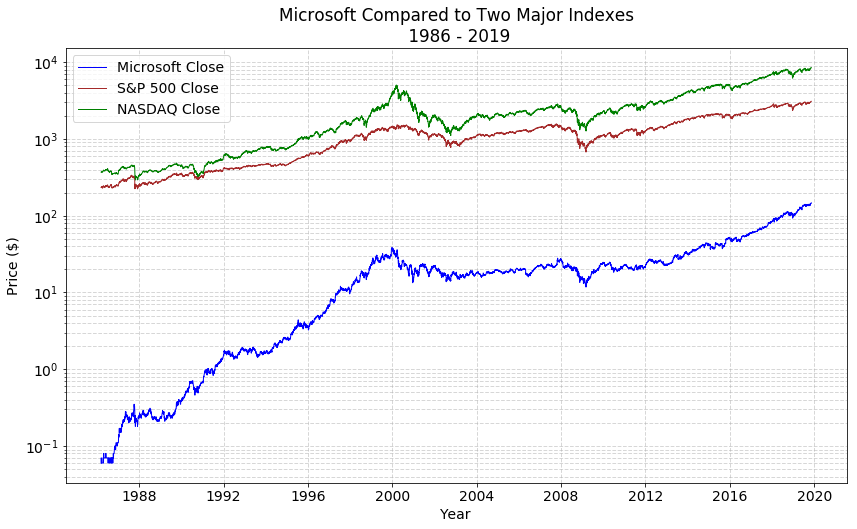

In [25]:
plt.figure(figsize = (14,8), linewidth=3, frameon = False)
scale = "log"
plot_stock_data(msft_data.close, "Microsoft Close", "blue", scale)
plot_stock_data(spy_500.close, "S&P 500 Close", "brown", scale)
plot_stock_data(nasdaq.close, "NASDAQ Close", "green", scale)
plt.title("Microsoft Compared to Two Major Indexes\n 1986 - 2019")
plt.show()

In [126]:
@interact(control=widgets.Dropdown(
    options=["msft_data",
             "spy_500",
             "nasdaq"
             ],
    description='Datasets'
))

def plot_df(control):
    plt.figure(figsize = (14,8), linewidth=3, frameon = False)
    data = eval(control)
    plot_data(data)

interactive(children=(Dropdown(description='Datasets', options=('msft_data', 'spy_500', 'nasdaq'), value='msft…

In [26]:
#plot_interactive_stock_data(df, "Microsoft stock 1986-2019")

In [27]:
msft_data["daily_log_return_msft"] = calculate_log_return(msft_data.close, msft_data.open)
msft_data["daily_return"] = calculate_return(msft_data.close, msft_data.open)

In [28]:
msft_data.head()

open  high   low  close      volume  dividends  stock_splits  \
Date                                                                       
1986-03-13  0.06  0.07  0.06   0.06  1031788800        0.0           0.0   
1986-03-14  0.06  0.07  0.06   0.07   308160000        0.0           0.0   
1986-03-17  0.07  0.07  0.07   0.07   133171200        0.0           0.0   
1986-03-18  0.07  0.07  0.06   0.06    67766400        0.0           0.0   
1986-03-19  0.06  0.07  0.06   0.06    47894400        0.0           0.0   

            daily_log_return_msft  daily_return  
Date                                             
1986-03-13               0.000000      0.000000  
1986-03-14              15.415068     16.666667  
1986-03-17               0.000000      0.000000  
1986-03-18             -15.415068    -14.285714  
1986-03-19               0.000000      0.000000

In [29]:
spy_500["daily_log_return_spy"] = calculate_log_return(spy_500.close, spy_500.open)
spy_500["daily_return"] = calculate_return(spy_500.close, spy_500.open)

In [30]:
nasdaq["daily_log_return_nasdaq"] = calculate_log_return(nasdaq.close, nasdaq.open)
nasdaq["daily_return"] = calculate_return(nasdaq.close, nasdaq.open)

In [31]:
#explain there is no problem using secondary market treasury rate - what Svetlio told me. Explain difference between markets.
#explain "risk-free"
three_month_treasury = pd.read_csv("three_month_treasury.csv")

In [32]:
three_month_treasury.head()

Date  Value
0  1954-01-04   1.33
1  1954-01-05   1.28
2  1954-01-06   1.28
3  1954-01-07   1.31
4  1954-01-08   1.31

In [33]:
three_month_treasury = set_date_index(three_month_treasury)

In [34]:
three_month_treasury = three_month_treasury.rename(columns = {"Value": "value"})

In [35]:
three_month_treasury.shape

(16456, 1)

In [36]:
#three_month_treasury.index.year.unique()

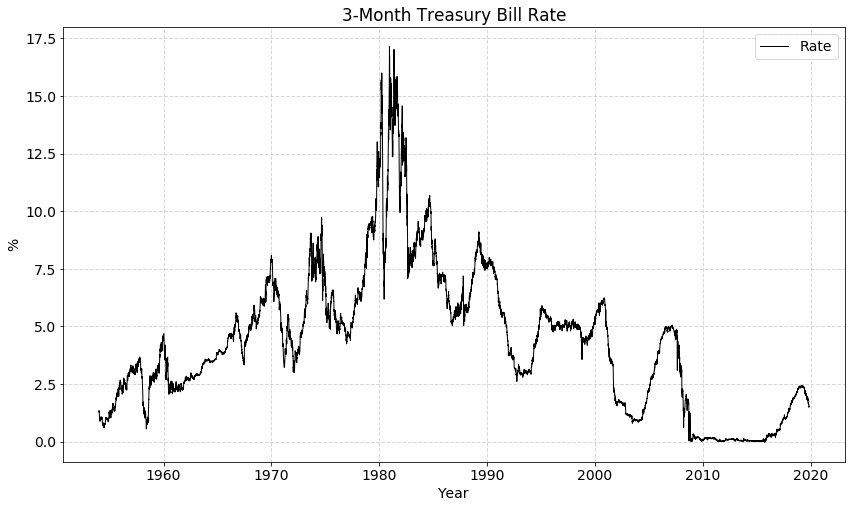

In [37]:
plt.figure(figsize = (14,8), linewidth=3, frameon = False)
plt.title("3-Month Treasury Bill Rate")
plot_stock_data(three_month_treasury.value, "Rate", "black", "linear")
plt.ylabel("%")
plt.show()

In [38]:
crude_oil_futures = pd.read_csv("crude_oil_futures.csv")

In [39]:
crude_oil_futures.tail()
#settle equals closing price for the day

Date   Open   High    Low   Last  Change  Settle    Volume  \
9199  2019-11-06  57.26  57.85  56.11  56.39    0.88   56.35  606612.0   
9200  2019-11-07  56.35  57.88  56.27  57.07    0.80   57.15  665028.0   
9201  2019-11-08  57.08  57.48  55.76  57.45    0.09   57.24  618762.0   
9202  2019-11-11  57.40  57.40  56.25  56.90    0.38   56.86  486317.0   
9203  2019-11-12  56.89  57.55  56.54  56.78    0.06   56.80  569382.0   

      Previous Day Open Interest  
9199                    396036.0  
9200                    371300.0  
9201                    352155.0  
9202                    317237.0  
9203                    280384.0

In [40]:
crude_oil_futures = set_date_index(crude_oil_futures)
crude_oil_futures.sample()

Open  High   Low   Last  Change  Settle    Volume  \
Date                                                            
2000-10-12  35.0  37.0  34.9  36.06     NaN   36.06  116368.0   

            Previous Day Open Interest  
Date                                    
2000-10-12                     78138.0

In [41]:
crude_oil_futures = crude_oil_futures.loc[crude_oil_futures.index > '1986-03-12']

In [42]:
crude_oil_futures.shape

(8464, 8)

In [43]:
crude_oil_futures["daily_log_return_oil"] = calculate_log_return(crude_oil_futures.Settle, crude_oil_futures.Open)
crude_oil_futures["daily_return"] = calculate_return(crude_oil_futures.Settle, crude_oil_futures.Open)

In [44]:
crude_oil_futures.sample()

Open   High    Low   Last  Change  Settle   Volume  \
Date                                                             
2000-12-12  29.6  29.74  28.95  29.68     NaN   29.68  60269.0   

            Previous Day Open Interest  daily_log_return_oil  daily_return  
Date                                                                        
2000-12-12                     73924.0              0.269906       0.27027

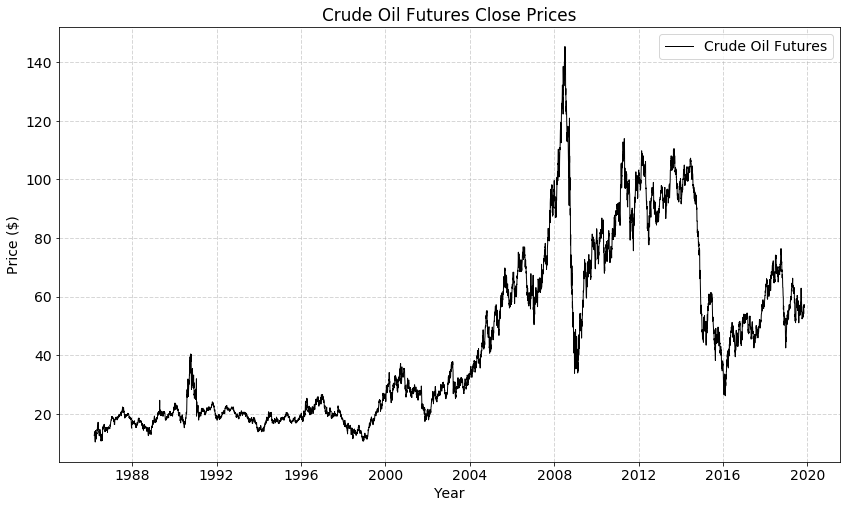

In [45]:
plt.figure(figsize = (14,8), linewidth=3, frameon = False)
plt.title("Crude Oil Futures Close Prices")
plot_stock_data(crude_oil_futures.Settle, "Crude Oil Futures", "black", "linear")
plt.show()

In [46]:
ecu_to_usd = pd.read_csv("ecu_to_usd_data.csv")
ecu_to_usd = ecu_to_usd.rename(columns = {
    "DATE": "Date",
    "EXUSEC": "value"})

In [47]:
ecu_to_usd.head()

Date   value
0  1978-12-01  1.3773
1  1979-01-01  1.3583
2  1979-02-01  1.3517
3  1979-03-01  1.3520
4  1979-04-01  1.3370

In [48]:
euro_usd_exchange_rate = pd.read_csv("eur_usd_data.csv")
euro_usd_exchange_rate = euro_usd_exchange_rate.rename(columns = {
    "DATE": "Date",
    "Value": "value"})
euro_usd_exchange_rate.head()

Date   value
0  1999-01-04  1.1789
1  1999-01-05  1.1790
2  1999-01-06  1.1743
3  1999-01-07  1.1632
4  1999-01-08  1.1659

In [49]:
ecu_to_usd = set_date_index(ecu_to_usd)
euro_usd_exchange_rate = set_date_index(euro_usd_exchange_rate)

In [50]:
euro_usd_exchange_rate.head()

value
Date              
1999-01-04  1.1789
1999-01-05  1.1790
1999-01-06  1.1743
1999-01-07  1.1632
1999-01-08  1.1659

In [51]:
#ecu_to_usd['Date'] = pd.to_datetime(ecu_to_usd['Date'], format='%Y-%m')

In [52]:
start_date = ecu_to_usd.index.min() - pd.DateOffset(day=1)
end_date = ecu_to_usd.index.max() + pd.DateOffset(day=31)

In [53]:
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'
ecu_to_usd = ecu_to_usd.reindex(dates, method='nearest')

In [54]:
ecu_to_usd.shape

(7336, 1)

In [55]:
ecu_to_usd.tail()

value
date              
1998-12-27  1.1756
1998-12-28  1.1756
1998-12-29  1.1756
1998-12-30  1.1756
1998-12-31  1.1756

In [56]:
eur_ecu_combined = pd.concat([ecu_to_usd,euro_usd_exchange_rate], ignore_index=False)
eur_ecu_combined.sample()

value
1989-07-02  1.0945

In [57]:
eur_ecu_combined = eur_ecu_combined.loc[eur_ecu_combined.index > '1986-03-12']

In [58]:
eur_ecu_combined.shape

(10019, 1)

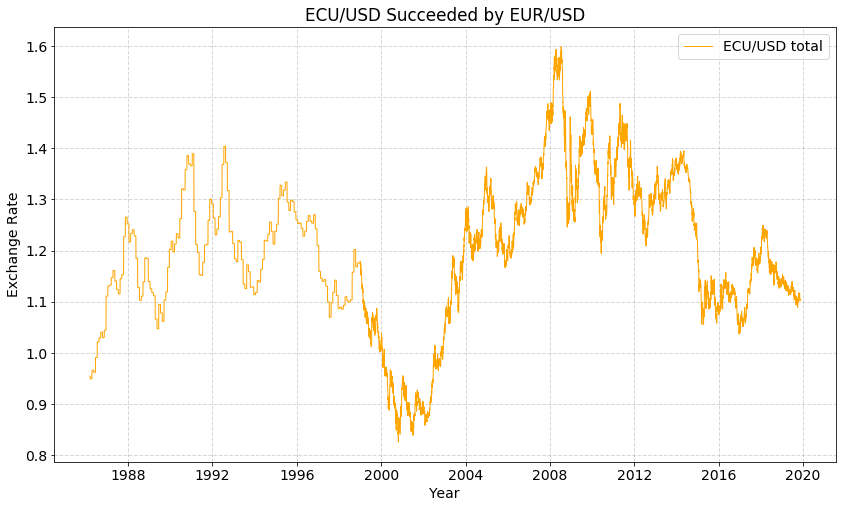

In [59]:
#U.S. Dollars to One Euro Community Unit/Euro
plt.figure(figsize = (14,8), linewidth=3, frameon = False)
plt.title("ECU/USD Succeeded by EUR/USD")
plot_stock_data(eur_ecu_combined,"ECU/USD total", "orange", "linear")
plt.ylabel("Exchange Rate")
plt.show()

In [60]:
#since we don't need such a big timeframe it is time to cut
#do not need this because I will drop all na values when I concat the tables.
#don't forget the shift() after you leave the data that you want. then remove the nan row
#explain holidays and the timeframe
three_month_treasury = three_month_treasury.loc[three_month_treasury.index > '1986-03-12']

In [61]:
#calculate excess return - the forecasted variable
msft_data = pd.concat([msft_data, three_month_treasury], axis = 1)

In [62]:
df1 = msft_data[msft_data.isna().any(axis=1)]

In [63]:
#all of these are holidays too
df1.index.unique()

DatetimeIndex(['1986-10-13', '1986-11-11', '1987-01-19', '1987-10-12',
               '1987-11-11', '1988-01-18', '1988-10-10', '1988-11-11',
               '1989-01-16', '1989-10-09', '1990-01-15', '1990-10-08',
               '1990-11-12', '1991-01-21', '1991-10-14', '1991-11-11',
               '1992-01-20', '1992-10-12', '1992-11-11', '1993-01-18',
               '1993-10-11', '1993-11-11', '1994-01-17', '1994-10-10',
               '1994-11-11', '1995-01-16', '1995-10-09', '1996-01-15',
               '1996-04-05', '1996-10-14', '1996-11-11', '1997-01-20',
               '1997-10-13', '1997-11-11', '1998-10-12', '1998-11-11',
               '1999-04-02', '1999-10-11', '1999-11-11', '2000-10-09',
               '2001-09-13', '2001-09-14', '2001-10-08', '2001-11-12',
               '2002-10-14', '2002-11-11', '2003-10-13', '2003-11-11',
               '2004-10-11', '2004-11-11', '2005-10-10', '2005-11-11',
               '2006-10-09', '2007-01-02', '2007-04-06', '2007-10-08',
      

In [64]:
df1.shape

(85, 10)

In [65]:
msft_data.shape

(8498, 10)

In [66]:
msft_data.dropna(axis=0, inplace = True)

In [67]:
msft_data.shape

(8413, 10)

In [68]:
msft_data["risk_premium"] = msft_data.daily_log_return_msft-msft_data.value

In [69]:
msft_data.head()

open  high   low  close        volume  dividends  stock_splits  \
Date                                                                         
1986-03-13  0.06  0.07  0.06   0.06  1.031789e+09        0.0           0.0   
1986-03-14  0.06  0.07  0.06   0.07  3.081600e+08        0.0           0.0   
1986-03-17  0.07  0.07  0.07   0.07  1.331712e+08        0.0           0.0   
1986-03-18  0.07  0.07  0.06   0.06  6.776640e+07        0.0           0.0   
1986-03-19  0.06  0.07  0.06   0.06  4.789440e+07        0.0           0.0   

            daily_log_return_msft  daily_return  value  risk_premium  
Date                                                                  
1986-03-13               0.000000      0.000000   6.59     -6.590000  
1986-03-14              15.415068     16.666667   6.54      8.875068  
1986-03-17               0.000000      0.000000   6.56     -6.560000  
1986-03-18             -15.415068    -14.285714   6.54    -21.955068  
1986-03-19               0.000000      0.000000   6.49     -6.490000

In [70]:
final_dataset_for_ml = pd.concat([msft_data.volume,
                                  spy_500.daily_log_return_spy,
                                  nasdaq.daily_log_return_nasdaq,
                                  crude_oil_futures.daily_log_return_oil,
                                  eur_ecu_combined.value,
                                  msft_data.risk_premium], axis = 1, ignore_index=False)

In [71]:
final_dataset_for_ml = final_dataset_for_ml.rename(columns = {
        "value": "EUR_USD_exchange_rate"})

In [72]:
final_dataset_for_ml.head()

volume  daily_log_return_spy  daily_log_return_nasdaq  \
1986-03-13  1.031789e+09              0.279132                 0.297418   
1986-03-14  3.081600e+08              1.430603                 0.188451   
1986-03-15           NaN                   NaN                      NaN   
1986-03-16           NaN                   NaN                      NaN   
1986-03-17  1.331712e+08             -0.797933                -0.054039   

            daily_log_return_oil  EUR_USD_exchange_rate  risk_premium  
1986-03-13            -10.851758                 0.9540     -6.590000  
1986-03-14             -0.626961                 0.9540      8.875068  
1986-03-15                   NaN                 0.9540           NaN  
1986-03-16                   NaN                 0.9540           NaN  
1986-03-17              5.448819                 0.9489     -6.560000

In [73]:
final_dataset_for_ml.dropna(inplace = True)

In [74]:
final_dataset_for_ml.shape

(8330, 6)

In [75]:
final_dataset_for_ml.head()

volume  daily_log_return_spy  daily_log_return_nasdaq  \
1986-03-13  1.031789e+09              0.279132                 0.297418   
1986-03-14  3.081600e+08              1.430603                 0.188451   
1986-03-17  1.331712e+08             -0.797933                -0.054039   
1986-03-18  6.776640e+07              0.471889                 0.134680   
1986-03-19  4.789440e+07             -0.076372                -0.188147   

            daily_log_return_oil  EUR_USD_exchange_rate  risk_premium  
1986-03-13            -10.851758                 0.9540     -6.590000  
1986-03-14             -0.626961                 0.9540      8.875068  
1986-03-17              5.448819                 0.9489     -6.560000  
1986-03-18             -0.145560                 0.9489    -21.955068  
1986-03-19             -5.279819                 0.9489     -6.490000

In [76]:
final_dataset_for_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8330 entries, 1986-03-13 to 2019-11-08
Data columns (total 6 columns):
volume                     8330 non-null float64
daily_log_return_spy       8330 non-null float64
daily_log_return_nasdaq    8330 non-null float64
daily_log_return_oil       8330 non-null float64
EUR_USD_exchange_rate      8330 non-null float64
risk_premium               8330 non-null float64
dtypes: float64(6)
memory usage: 455.5 KB


In [122]:
def plot_interactive_function(df):    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['volume'],
                    name="Microsoft Daily Traded Volume",
                    line_color='blueviolet',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['daily_log_return_spy'],
                    name="S&P 500 daily return",
                    line_color='green',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['daily_log_return_nasdaq'],
                    name="Nasdaq daily return",
                    line_color='red',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['daily_log_return_oil'],
                    name="Crude oil daily return",
                    line_color='darkkhaki',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['EUR_USD_exchange_rate'],
                    name="EUR/USD exchange rate",
                    line_color='darkgoldenrod',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['risk_premium'],
                    name="Target value: Risk premium",
                    line_color='brown',
                    opacity=0.8))

    # Use date string to set xaxis range
    fig.update_layout(title_text='Explore data',
                  xaxis_rangeslider_visible=True)
    #fig.update_layout(xaxis_range=[df.index.min(), df.index.max()],
                      #title_text="Plot predictors and target data")
    fig.show()
    
plot_interactive_function(final_dataset_for_ml)

In [91]:
@interact(control=widgets.Dropdown(
    options=["volume",
             "daily_log_return_spy",
             "daily_log_return_nasdaq",
             "daily_log_return_oil",
             "EUR_USD_exchange_rate",
             "risk_premium"],
    description='Columns'
))

def plot_df(control):
    plt.figure(figsize = (14,8), linewidth=3, frameon = False)
    data = eval('final_dataset_for_ml.{}'.format(control))
    acp(data)

interactive(children=(Dropdown(description='Columns', options=('volume', 'daily_log_return_spy', 'daily_log_re…

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. **read again about that**

Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [101]:
@interact(control=widgets.Dropdown(
    options=["volume",
             "daily_log_return_spy",
             "daily_log_return_nasdaq",
             "daily_log_return_oil",
             "EUR_USD_exchange_rate",
             "risk_premium"],
    description='Columns'
))

def plot_df(control):
    plt.figure(figsize = (14,8), linewidth=3, frameon = False)
    data = eval('final_dataset_for_ml.{}'.format(control))
    test_stationarity(data)

interactive(children=(Dropdown(description='Columns', options=('volume', 'daily_log_return_spy', 'daily_log_re…

**TODO**: Add formula, explain Dickey-Fuller
The test statistic for the volume is significantly below the critical values, even the one percent. So we can reject the null hypothesis and say the data is stationary.

*Write it better. Put the hypothesis explanation above the plots. Explain critical values*

Now lets check the other variables. **Make it with a dropdown**

### What is "lags used" in the report
#### Check what Mitko sent me
#### Autocorrelation
#### Remove stationarity from the two columns


The above list does not look good. But after observation of the dates thing got more clearer. The dates are different holidays in the us. It looks like the U.S. Treasury is having a bit different holiday schedule than the Stock Exchange. So it is possible to have rates from one or the other. For this reason the best choice here will be to remove the holiday rows.

**TODO**: The final data that I will use - put it in separate dataframe - this includes returns, volume, oil, eventually currencies

**TODO**: *do it after you merge all preprocessed data into one dataframe*

In [80]:
#three_month_treasury.shape, msft_data.shape, spy_500.shape, nasdaq.shape

In [81]:
#concat tbill and msft
#df = pd.concat([three_month_treasury, msft_data], axis = 1)

In [82]:
#df.dropna(inplace = true) - the way to remove my data
#df1 = df[df.isna().any(axis=1)]

In [83]:
#df1.count()

In [84]:
#Plot dickey fuller for close prices and for return to make comparison and see if you need to make new data stationary
#Explain why returns not prices - because of the stationary shit
#Put the photo from Svetlio and the citations in the project
#Then when everything is stationary calculate the excess return on the stock. This will be the forecasted value

#Nasdaq, SPY and Volume will be predictors
#Add currency, commodities


In [85]:
#Жужи код
#for feature in data_train.columns:
    
#    result = adfuller(pd.concat([data_train[feature], data_test[feature]]))
    
#    print(feature)
#    print('ADF Statistic: %f' % result[0])
#    print('p-value: %f' % result[1])
#    print('Critical Values:')
#    for key, value in result[4].items():
#        print('\t%s: %.3f' % (key, value))

In [86]:
#isBusinessDay = BDay().onOffset
#business_days_check = pd.to_datetime(df.index).map(isBusinessDay)
#business_days_check.shape
#business_days_check.unique()

#### Add S&P500 and Nasdaq - check which column
#### Add 3-month t-bill
#### Calculate the return
#### Plot the data to explore it further for trends, seasonality. The data should be stationary for our algorithms. It will be important to remove trends and seasonality before fitting the models.
##### I will then scale the data for more convenience, split it , apply gridcsearch and test models.

We can clearly see that there is an upward trend (especially after 2012) in the price of Microsoft stock over time. Due to the long period and the limitations of the plot above I cannot identify seasonality just by looking at the plot. But since this is not just guess work, I will apply some calculations to identify and remove trends and seasonality from my data.
#### To-do! Explain all about stationarity, and removing trends.
##### The idea - Make the data time independent (as much as possible). Make it stationary

**!Pipeline, Pickle**

**lags for the time, to make it independent!**

**forecasting**

**based on what forecasting** - check and sklearn offerings

**unsupervised learning - you can do Nothing :D, or some other metrics  - linked to clustering if I use it or bring it to supervised learning**

***think of different types of scalers, which one to use, or check several***

check how to make stratified sample in Python

try to show and analyze all possible information from the data. What can I extract from it?

### Check paper "Regime Switching in Stock Market Returns"
#### Maybe to expand my project in future...

